## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import os

import visualkeras

from tqdm.notebook import tqdm

data_path = "../dataset/data/"
cell_types = os.listdir(data_path)

np.random.seed(42)
 
# numpy version == 1.19.3 in order to make tensorflow Recurrent layer works
assert(np.version.version=="1.19.3")

## Load the data

In [2]:
def load():
    print("load()")
    full_train_data = np.array([])
    full_valid_data = np.array([])
    full_test_data = np.array([])
    full_train_labels = np.array([])
    full_valid_labels = np.array([])
    full_test_labels = np.array([])

    dirs = os.listdir(data_path)
    for folder in tqdm(dirs):
        (train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load_clean_data(folder)
        # print(f"{folder} loaded")
        
        # train
        full_train_data = np.append(full_train_data, train_data)
        full_train_labels = np.append(full_train_labels, train_labels)
        # valid
        full_valid_data = np.append(full_valid_data, valid_data)
        full_valid_labels = np.append(full_valid_labels, valid_labels)
        # test
        full_test_data = np.append(full_test_data, test_data)
        full_test_labels = np.append(full_test_labels, test_labels)

    # ? reshaping
    full_train_data = full_train_data.reshape(len(full_train_labels), 5, 100, 1)
    full_valid_data = full_valid_data.reshape(len(full_valid_labels), 5, 100, 1)
    full_test_data = full_test_data.reshape(len(full_test_labels), 5, 100, 1)

    return (
        (full_train_data, full_train_labels),
        (full_valid_data, full_valid_labels),
        (full_test_data, full_test_labels)
    )

In [3]:
def load_clean_data(folder_name):
    # data
    train_data = np.load(f"{data_path}{folder_name}/train_data.npy")
    valid_data = np.load(f"{data_path}{folder_name}/valid_data.npy")
    test_data = np.load(f"{data_path}{folder_name}/test_data.npy")
    # labels
    train_labels = np.load(f"{data_path}{folder_name}/train_labels.npy")
    valid_labels = np.load(f"{data_path}{folder_name}/valid_labels.npy")
    test_labels = np.load(f"{data_path}{folder_name}/test_labels.npy")
    # return complete tuples
    return ((train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels))

## Create the model

### Load the data

In [4]:
(train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load()

load()


In [5]:
# visualize some stats about the data
print(f"{len(train_data)} training genes")
print(f"{len(valid_data)} validation genes")
print(f"{len(test_data)} test genes")
print(f"mean: {np.mean(train_data)}\nstd: {np.std(train_data)}")

369544 training genes
369544 validation genes
369432 test genes
mean: -8.957302339603253e-17
std: 0.999999999999999


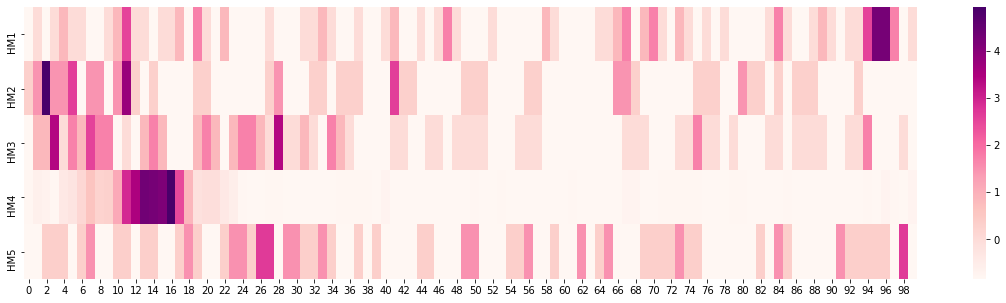

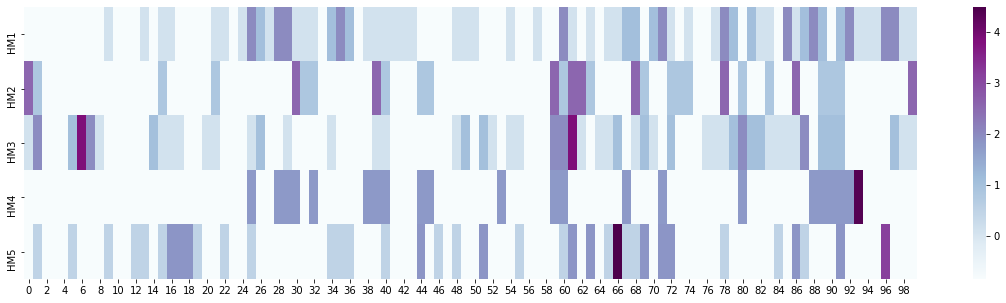

In [6]:
def plot_gene(gene,label):
    gene = gene.reshape(5,100)
    df = pd.DataFrame(gene, index=['HM1','HM2','HM3','HM4','HM5'])
    plt.figure(figsize=(20, 5))
    sns.heatmap(df, cmap=("RdPu" if label==1 else "BuPu"))

# test the function
plot_gene(train_data[0],train_labels[0])
plot_gene(train_data[1],train_labels[1])

## Utility functions

In [7]:
def plot_metrics(history):
    # AUC
    plt.plot(history.history["auc"], label="auc")
    plt.plot(history.history["val_auc"], label="val_auc")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.ylim([0.65, 1])
    plt.legend(loc="lower right")
    plt.show()
    # loss
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim([0,1])
    plt.legend(loc="lower right")
    plt.show()

## Modeling
Here we build several incremental models.

### Random Forest Classifier
`Random Forest Classifier | min: 0.706171675739049 - max: 0.8874003754283708 - mean: 0.7942767483097146`

In [8]:
train_data = train_data.reshape(len(train_data),5*100)
valid_data = valid_data.reshape(len(valid_data),5*100)
test_data = test_data.reshape(len(test_data),5*100)

In [9]:
clf = RandomForestClassifier(max_depth=20,n_estimators=150, random_state=0)
clf.fit(train_data, train_labels)

RandomForestClassifier(max_depth=20, n_estimators=150, random_state=0)

In [10]:
clf.score(test_data,test_labels)
roc_auc_score(test_labels, clf.predict_proba(test_data)[:,1])

0.8109613277479903

In [11]:
aucs = []
unit = 6597
for i in tqdm(range(56)):            
    test_auc = roc_auc_score(test_labels[i*unit:(i+1)*unit], clf.predict_proba(test_data[i*unit:(i+1)*unit])[:,1])
    aucs.append(test_auc)    
print(f"Random Forest Classifier | min: {min(aucs)} - max: {max(aucs)} - mean: {np.mean(aucs)}")
df_results = pd.DataFrame(list(zip(cell_types, aucs)),
               columns =['Cell-Type','AUC'])
# save results
df_results.to_csv("../results/Random_Forest_Classifier.csv",index=None)


Random Forest Classifier | min: 0.706171675739049 - max: 0.8874003754283708 - mean: 0.7942767483097146


['../models/Random_Forest_Classifier.joblib']

### FNN (Base model)

`Base_NN | min: 0.6968067288398743 - max: 0.8944201469421387 - mean: 0.7930427257503782`

`Base_NN - separated | min: 0.7143731117248535 - max: 0.9025979042053223 - mean: 0.7986104562878609`

In [67]:
train_data = train_data.reshape(len(train_data),5,100)
valid_data = valid_data.reshape(len(valid_data),5,100)
test_data = test_data.reshape(len(test_data),5,100)

In [68]:
model = models.Sequential(name="Base_NN")
model.add(layers.Flatten(input_shape=(5, 100)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation="sigmoid"))

### Model - DeepChrome

`Deep_Chrome | min: 0.7167153358459473 - max: 0.9021117687225342 - mean: 0.8032737289156232`

`Deep_Chrome-separated | min: 0.7227053642272949 - max: 0.9179351329803467 - mean: 0.8068524854523795`

In [14]:
train_data = train_data.reshape(len(train_data),100,5)
valid_data = valid_data.reshape(len(valid_data),100,5)
test_data = test_data.reshape(len(test_data),100,5)

In [15]:
model = models.Sequential(name="Deep_Chrome")
model.add(layers.Conv1D(filters=50, kernel_size=10, activation="relu", input_shape=(100,5)))
model.add(layers.MaxPooling1D(pool_size=5))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(625, activation='relu'))
model.add(layers.Dense(125, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Model - UltraChrome

`Ultra_Chrome | min: 0.714259684085846 - max: 0.9034337401390076 - mean: 0.8045275743518557`

`Ultra_Chrome - separated | min: 0.7268062829971313 - max: 0.9202893376350403 - mean: 0.8114221681441579`

Hyper-parameters:
- **filters** : 50 | 100
- **neurons**: high: 64+256+64 | low: 32+128+32 | deep: 64+256+256+64
- **dropout**: on | off
- **batch norm**: on | off
---
- `50|Low|No|No` : `Ultra_Chrome | min: 0.6526966094970703 - max: 0.9346764087677002 - mean: 0.7641739281160491`
- `100|Low|No|No` : `Ultra_Chrome | min: 0.6532466411590576 - max: 0.938978910446167 - mean: 0.7648651003837585`
- `100|High|No|No` : `Ultra_Chrome | min: 0.6534548997879028 - max: 0.9363148212432861 - mean: 0.7629680676119668`
- `100|High|Yes|No` : `Ultra_Chrome | min: 0.654558539390564 - max: 0.9329816102981567 - mean: 0.7630851109113012`
- `100|High|Yes|Yes` : `Ultra_Chrome | min: 0.6521378755569458 - max: 0.9367374181747437 - mean: 0.7655470222234726`
- `100|Deep|Yes|Yes` : `Ultra_Chrome | min: 0.6478064060211182 - max: 0.9374117851257324 - mean: 0.7645122249211583`

In [75]:
train_data = train_data.reshape(len(train_data),5,100,1)
valid_data = valid_data.reshape(len(valid_data),5,100,1)
test_data = test_data.reshape(len(test_data),5,100,1)

In [77]:
model = models.Sequential(name="Ultra_Chrome")
# stage 1 => CONV 2D
model.add(layers.Conv2D(100, 5, activation="relu", input_shape=(5,100,1), padding="same"))
model.add(layers.MaxPooling2D(pool_size=(1,5)))
# stage 2 => FNN
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
# final stage
model.add(layers.Dense(1, activation='sigmoid'))

### ChromeR
> needs `numpy 1.19.3`

`ChromeR | min: 0.706201434135437 - max: 0.8871307969093323 - mean: 0.7961249468582017`

`ChromeR - separated | min: 0.710761547088623 - max: 0.902295708656311 - mean: 0.8009782103555543`

Hyper-parameters:
- **LSTM units**: 128 | 64
- **Neurons per dense**: 625+125 | 250+50 
- **Batch norm**: on | off

In [22]:
train_data = train_data.reshape(len(train_data),5,100)
valid_data = valid_data.reshape(len(valid_data),5,100)
test_data = test_data.reshape(len(test_data),5,100)

In [23]:
model = models.Sequential(name="ChromeR")
model.add(layers.Bidirectional(layers.LSTM(128, activation="relu"), input_shape=(5, 100)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(625, activation='relu'))
model.add(layers.Dense(125, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Visualize the model

Model: "Ultra_Chrome"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 5, 100, 100)       2600      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 20, 100)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 20, 100)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                640064    
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
dense_56 (Dense)             (None, 256)              

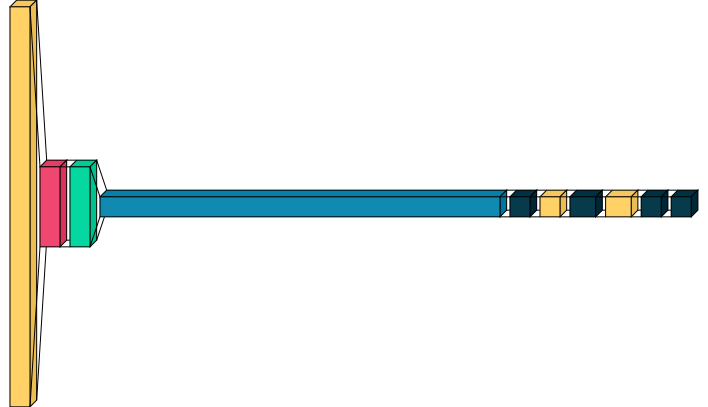

In [78]:
model.summary()
visualkeras.layered_view(model)

## Training

### Unique Training

In [82]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["AUC"])

checkpoint_filepath = './'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

history = model.fit(train_data, train_labels, epochs=10, 
                    validation_data=(valid_data, valid_labels), 
                    callbacks=[model_checkpoint_callback], verbose=2)

# load best model
model.load_weights(checkpoint_filepath)

# saving the model
model.save(f"../models/{model.name}")

Epoch 1/10
11549/11549 - 277s - loss: 0.5749 - auc: 0.7420 - val_loss: 0.5210 - val_auc: 0.7846
Epoch 2/10
11549/11549 - 299s - loss: 0.5663 - auc: 0.7534 - val_loss: 0.5265 - val_auc: 0.7861
Epoch 3/10
11549/11549 - 307s - loss: 0.5618 - auc: 0.7591 - val_loss: 0.5166 - val_auc: 0.7881
Epoch 4/10
11549/11549 - 290s - loss: 0.5578 - auc: 0.7637 - val_loss: 0.5162 - val_auc: 0.7900
Epoch 5/10
11549/11549 - 293s - loss: 0.5541 - auc: 0.7678 - val_loss: 0.5148 - val_auc: 0.7905
Epoch 6/10
11549/11549 - 287s - loss: 0.5515 - auc: 0.7706 - val_loss: 0.5171 - val_auc: 0.7889
Epoch 7/10
11549/11549 - 284s - loss: 0.5489 - auc: 0.7735 - val_loss: 0.5133 - val_auc: 0.7916
Epoch 8/10
11549/11549 - 283s - loss: 0.5468 - auc: 0.7756 - val_loss: 0.5129 - val_auc: 0.7916
Epoch 9/10
11549/11549 - 299s - loss: 0.5444 - auc: 0.7780 - val_loss: 0.5160 - val_auc: 0.7902
Epoch 10/10
11549/11549 - 302s - loss: 0.5428 - auc: 0.7797 - val_loss: 0.5144 - val_auc: 0.7903
INFO:tensorflow:Assets written to: ../m

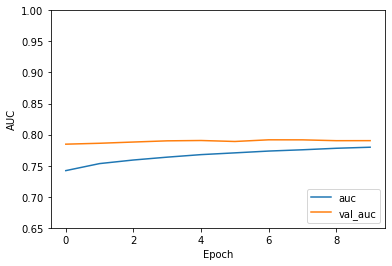

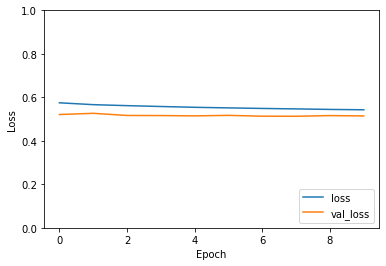

In [83]:
plot_metrics(history)

## Validation - Hyper-parameter tuning

In [84]:
def validate_model(model_name):
    # load model 
    model = tf.keras.models.load_model(f"../models/{model_name}")
    aucs = []
    unit = 6597
    for i in tqdm(range(56)):    
        _, valid_auc = model.evaluate(valid_data[i*unit:(i+1)*unit], valid_labels[i*unit:(i+1)*unit], verbose=0)
        aucs.append(valid_auc)
        
    print(f"{model.name} | min: {min(aucs)} - max: {max(aucs)} - mean: {np.mean(aucs)}")

In [85]:
model_name="Ultra_Chrome"
validate_model(model_name)


Ultra_Chrome | min: 0.6477327346801758 - max: 0.9362199306488037 - mean: 0.7631777971982956


## Test Unique Model

In [86]:
aucs = []
unit = 6597
for i in tqdm(range(56)):    
    _, test_auc = model.evaluate(test_data[i*unit:(i+1)*unit], test_labels[i*unit:(i+1)*unit], verbose=0)
    aucs.append(test_auc)
    
print(f"{model.name} | min: {min(aucs)} - max: {max(aucs)} - mean: {np.mean(aucs)}")

# saving the results
df_results = pd.DataFrame(list(zip(cell_types, aucs)),
               columns =['Cell-Type','AUC'])
df_results.to_csv(f"../results/{model.name}.csv",index=None)


Ultra_Chrome | min: 0.7196324467658997 - max: 0.9043508768081665 - mean: 0.8028575160673687


-----
## Separated Training and Testing

In [63]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["AUC"])

separated_models = []
unit = 6597

checkpoint_filepath = './'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

for i in tqdm(range(56)):
    new_model = model
    history = new_model.fit(train_data[i*unit:(i+1)*unit], train_labels[i*unit:(i+1)*unit],
                            validation_data=(valid_data[i*unit:(i+1)*unit], valid_labels[i*unit:(i+1)*unit]),
                            epochs=10,  # todo: modify number of epochs
                            callbacks=[model_checkpoint_callback], verbose=0) 
    # load best model
    new_model.load_weights(checkpoint_filepath)

    # saving the model
    separated_models.append(new_model)
    new_model.save(f"../models/separated/{new_model.name}/Cell-{i+1}")
    

INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-1\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-2\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-3\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-4\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-5\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-6\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-7\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-8\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-9\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-10\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-11\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-12\assets
INFO:tensorflow:Assets written to: ../models/separated/Base_NN/Cell-13\as

### Test Separate Models

In [64]:
aucs = []
unit = 6597
for i in tqdm(range(56)):    
    _, test_auc = separated_models[i].evaluate(test_data[i*unit:(i+1)*unit], test_labels[i*unit:(i+1)*unit], verbose=0)
    aucs.append(test_auc)
    
print(f"{model.name} - separated | min: {min(aucs)} - max: {max(aucs)} - mean: {np.mean(aucs)}")

# saving the results
df_results = pd.DataFrame(list(zip(cell_types, aucs)),
               columns =['Cell-Type','AUC'])
df_results.to_csv(f"../results/{model.name}-separated.csv",index=None)


Base_NN - separated | min: 0.7143731117248535 - max: 0.9025979042053223 - mean: 0.7986104562878609


---
### Best / Worst Predictions

In [87]:
best,worst = None,None
best_position,worst_position = None,None

test_labels = test_labels.reshape(len(test_labels),1)
predictions = model.predict(test_data)

diffs = abs(predictions-test_labels)

differences = pd.DataFrame(pd.DataFrame(list(diffs),
               columns =['Difference']))

differences.sort_values(by=['Difference'], inplace=True)

show = 5

Worst 5 guesses


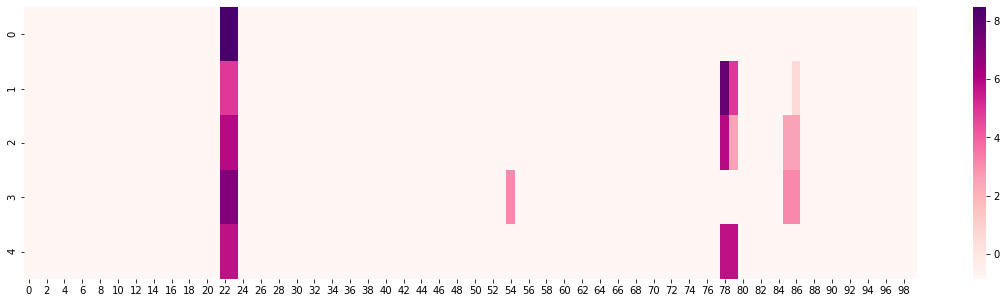

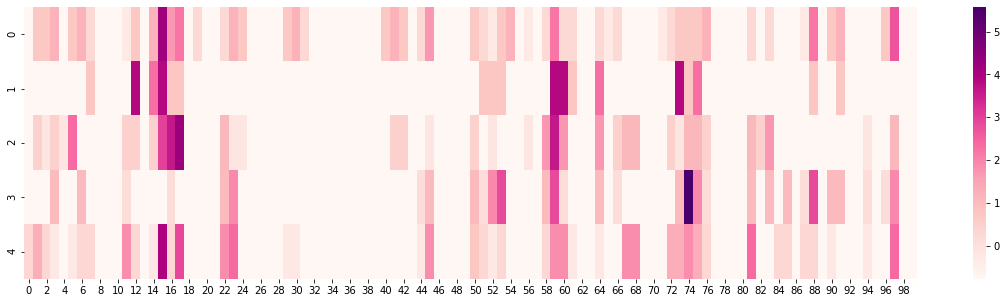

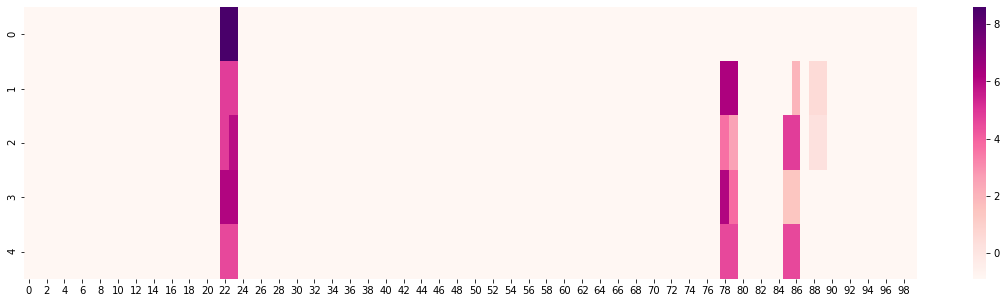

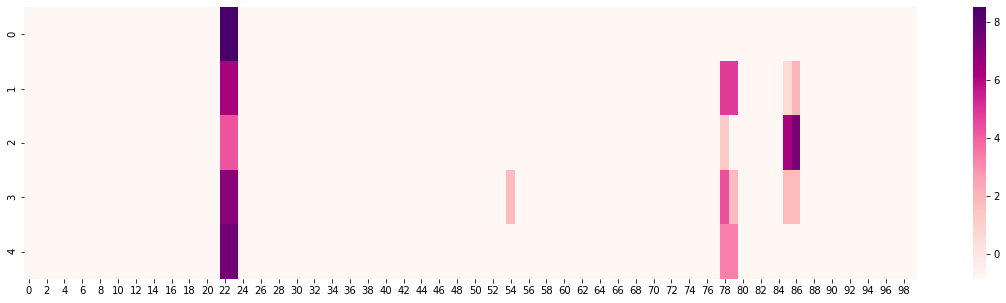

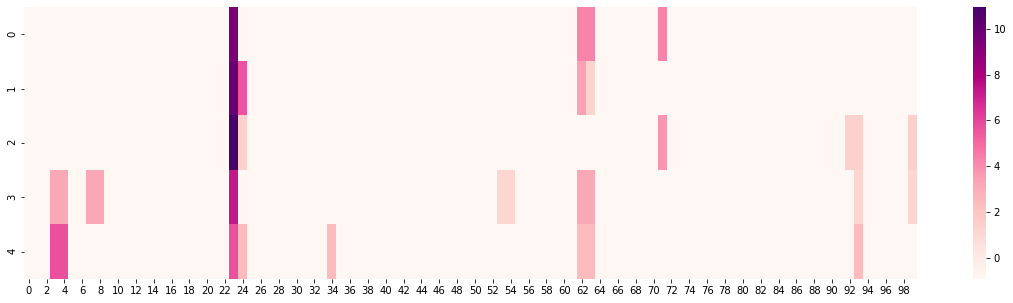

In [89]:
print(f"Worst {show} guesses")
for gene in list(differences.tail(show).index):    
    plot_gene(test_data[gene],test_labels[gene])

Best 5 guesses


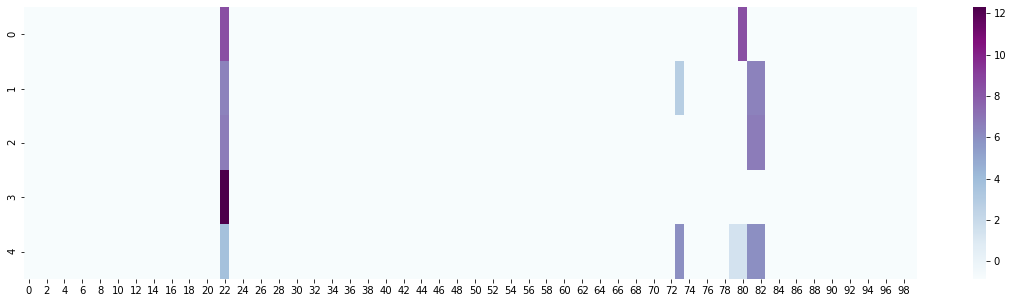

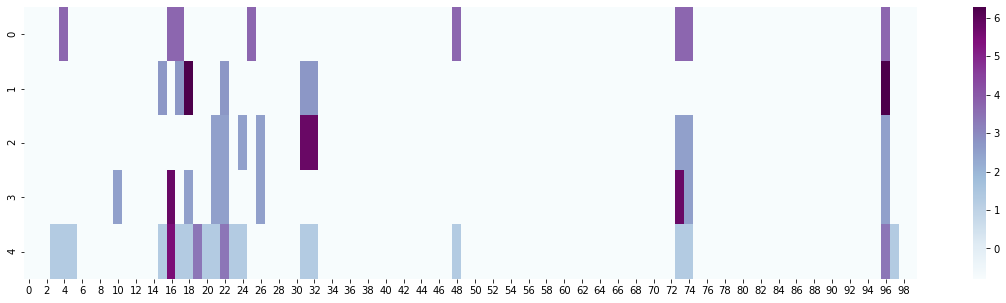

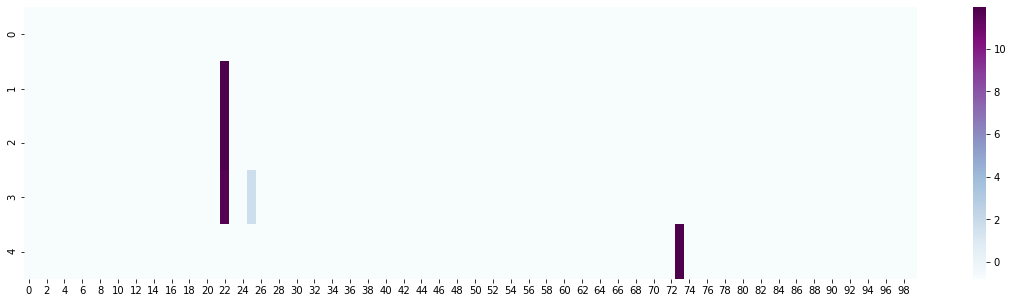

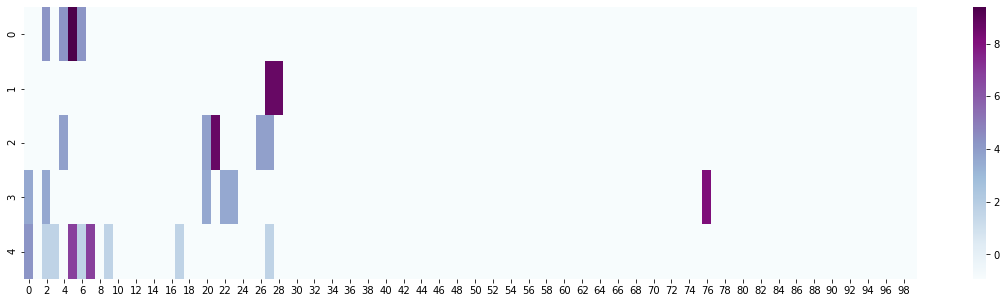

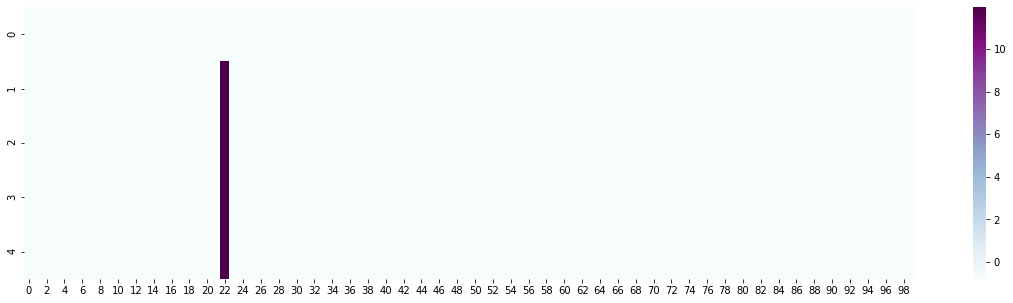

In [90]:
print(f"Best {show} guesses")
for gene in list(differences.head(show).index):    
    plot_gene(test_data[gene],test_labels[gene])